In [15]:
# With a clean dataset of all climbing routes and all sport routes across states, we can now analyze:

# The distribution of sport climbing routes across states by grade.
    # Which state has the hardes sport climbing routes (most routes >=8a)?
    # How many hard grades (>= 8a) are there in the states?
    # Which state has the most sport climbing routes?
    # Since trad climbing is very common in the US, which state has the most trad routes?
    # Which state has the most sport climbing routes relative to all types of climbing?

    # For a more fair/relevant comparison, lets consider state area:
        # Which state has the most dense distribution of sport routes?


# Analysis of US Rock climbing data
After extracting and cleaning OpenBeta's scrape of Mountain Projects database of rock climbs within the US (https://github.com/OpenBeta/climbing-data), further cleaning of the data was performed to obtain a clean file for analysis (data_preparation.ipynb). The result was saved under Data_final.xslx.



In [16]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import glob

# import the data
data = pd.read_excel("G:\My Drive\Trainings\Python\Trainings_file\climbing project\Cleaned dataset\Data_final.xlsx")

# for normalization of the route count to the the size of the state later in the analysis, 
# we generate a file containing the state size outside of python and import it afterwards.

# First, we export the states abbrevation from our data, which we need to align the two datasets externally.
all_states_np = data['State'].unique()
all_states_df = pd.DataFrame(all_states_np)
all_states_df.to_excel('G:\My Drive\Trainings\Python\Trainings_file\climbing project\Cleaned dataset\All_states_vec.xlsx', index = False)

# The states from our dataset were matched with the size of each state in Excel.
# The size was obained from: https://statesymbolsusa.org/symbol-official-item/national-us/uncategorized/states-size
# We now import the generated file containing the sizes.
state_size = pd.read_excel("G:\My Drive\Trainings\Python\Trainings_file\climbing project\Cleaned dataset\State_size.xlsx")
data = data.merge(state_size, on='State', how='outer')



In [17]:
# Make sure the column 'French grading' is of type str so the x-axis in graphs is sorted correctly.
# To avoid errors with NaN values we rename them to blanks.
data.fillna('', inplace=True)
data['French_grading'] = data['French_grading'].astype("string")

# filter the data set for only sport routes.
# Sport routes are labelled as TRUE in the df which is interpreted as 1 by Python.
# We create a copy of sport independent from data.
sport = data[data.sport == 1].copy()
# Filter out ungraded routes
sport = sport[sport['French_grading'] != '']

# We do the same for trad routes.
trad = data[data.trad == 1].copy()
trad = trad[trad['French_grading'] != '']


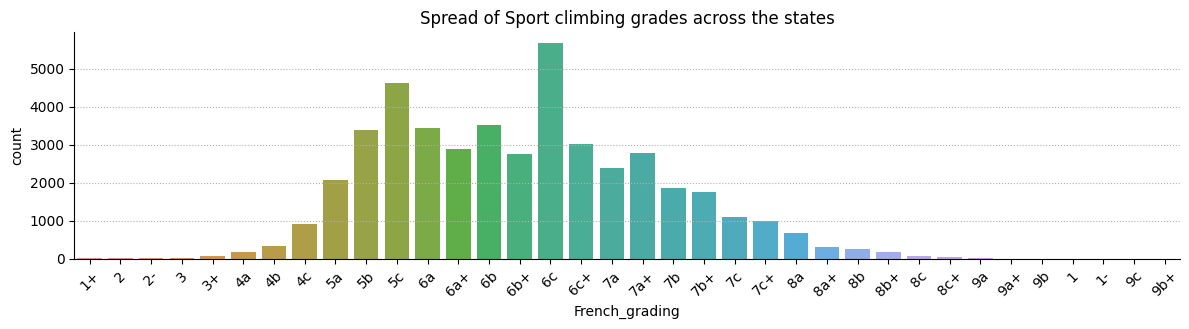

In [18]:
# plot the spread of grades across the states in a count plot.
total_sport_count_plot = sns.catplot(x= 'French_grading', kind = 'count', data = sport, height= 3, aspect= 4)

# add gridlines for easier readability.
plt.grid(which= 'major', axis= 'y', linestyle= 'dotted')

# rotate the x axis labels to make it more readable.
plt.xticks(rotation=45)
# add a title
plt.title('Spread of Sport climbing grades across the states')
# Show the plot
plt.show()


In the graph above we can see that most sport climbing routes in the US are graded between 5a and 7b. In the following we want to plot the same distribution but for states individually as a more high level overview.

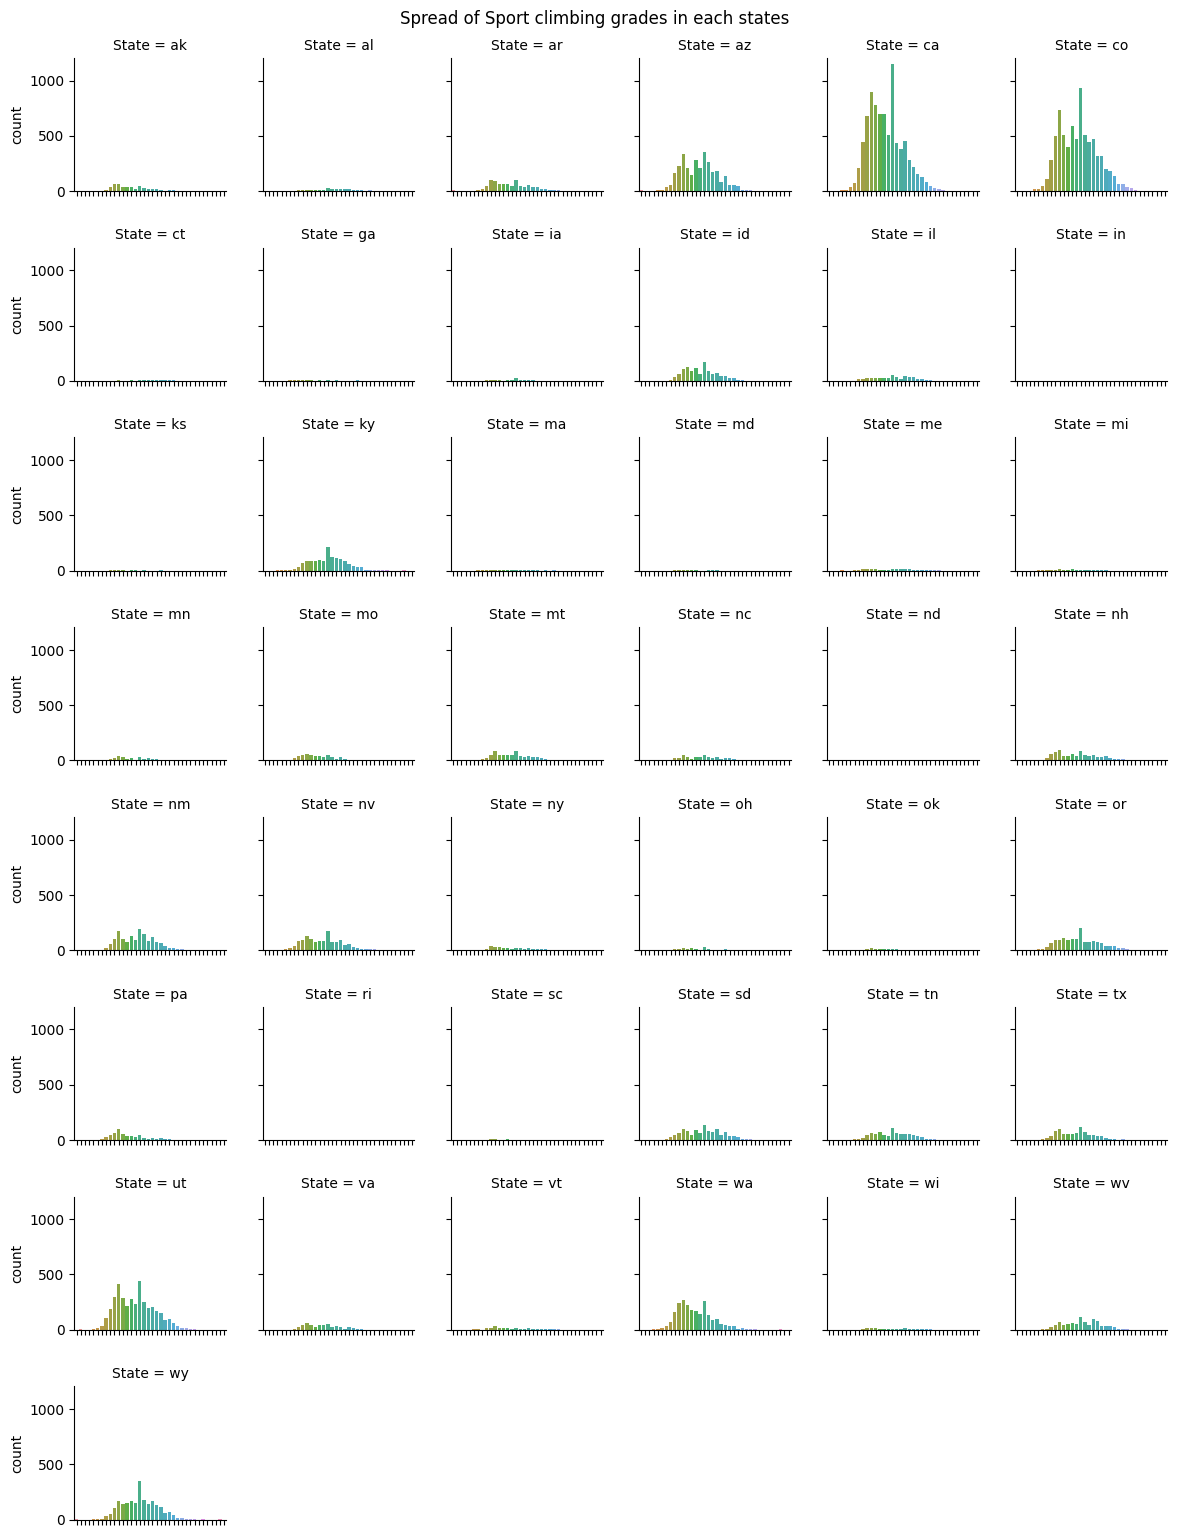

In [19]:
# Plot the spread of grades across the states in a count plot.
pp= sns.catplot(x= 'French_grading', kind = 'count', data = sport, col = 'State', col_wrap= 6, height= 2,
                col_order= sorted(sport['State'].unique()))

# Add a title to the FaceGrid and position it above the graph.
pp.fig.subplots_adjust(top=0.95)
pp.fig.suptitle('Spread of Sport climbing grades in each states')



# remove the labels to make it more readable for a purely high level overview.
sns.FacetGrid.set_xticklabels(self= pp, label=None)
sns.FacetGrid.set(self=pp, xlabel=None)

# Show the plot
plt.show()

The distribution of sport climbing routes across states seems to be quite heterogeneous. Next we want to get a more comprehensive overview of that finding by plotting the total count of sport routes in every state and the states proportion (%) of all sport routes in the US. 

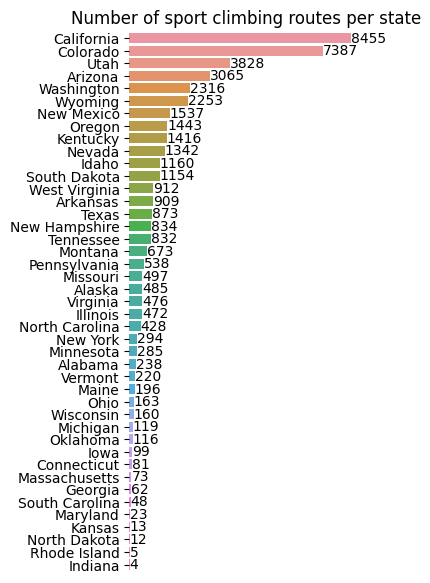

In [20]:
# adjust figure size and create a countplot counting all sport routes. List the occurences in descending order.
plt.figure(figsize=(3,7))
state_sport_counts_plot = sns.countplot(data = sport, y = 'State_name_full',
            order= sport['State_name_full'].value_counts().index)

# remove the frame from the plot as well as the x-axis. Since we label the bars, the axis is not needed.
sns.despine(left=True, bottom=True)
state_sport_counts_plot.set(xlabel=None, xticklabels=[], ylabel=None)
state_sport_counts_plot.tick_params(bottom=False)

# Add the count of each bar to the graph.
plt.bar_label(container=state_sport_counts_plot.containers[0], labels=sport['State'].value_counts())

# Add a title
plt.title('Number of sport climbing routes per state')

plt.show()

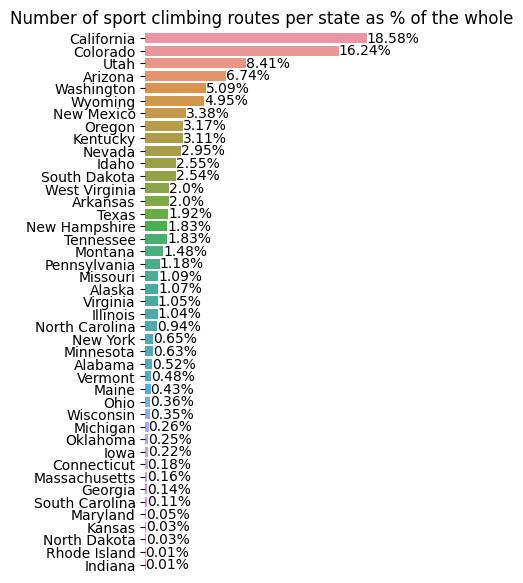

In [21]:
# Here we want to plot the % instead of the count.

# adjust figure size and create a countplot counting all sport routes. List the occurences in descending order.
plt.figure(figsize=(3,7))
stateperc = sns.countplot(data = sport, y = 'State_name_full',
            order= sport['State_name_full'].value_counts().index)

# remove the frame from the plot as well as the x-axis. Since we label the bars, the axis is not needed.
sns.despine(left=True, bottom=True)
stateperc.set(xlabel=None, xticklabels=[], ylabel=None)
stateperc.tick_params(bottom=False)

# Calculate the percentage of sport routes of each state as a fraction of the total.
state_sport_counts = sport['State'].value_counts()
total_state_sport = len(sport)
state_sport_percentages = (state_sport_counts / total_state_sport) * 100
# Round the percentage to two decimals.
state_sport_percentages = state_sport_percentages.round(2)

# Label the plot with the percentages.
plt.bar_label(container=stateperc.containers[0], labels=(state_sport_percentages.astype(str) + '%'))

# Add a title
plt.title('Number of sport climbing routes per state as % of the whole')

plt.show()

Since states are vastly different in size, lets look at the density of sport climbing routes within each state to have a more normalized comparison. Therefore we use data on size obtained from: https://statesymbolsusa.org/symbol-official-item/national-us/uncategorized/states-size. 
A sample of the dataset is shown in the table below.

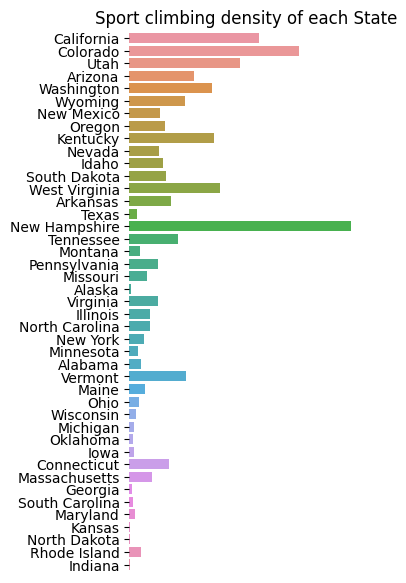

In [22]:
# Transform the np array of sport route counts to a dataframe and merge it with the state_size dataframe, only keeping states present in our dataset.
# Save the new df as state_size_norm_data.
state_sport_counts_df = pd.DataFrame(state_sport_counts)
state_sport_counts_df.rename(columns={'count': 'sport_route_count'}, inplace=True)
state_size_norm_data = state_size.merge(state_sport_counts_df, on='State', how='right')

# Add a new column containing the normalized sport routes as a fraction of state size.
state_size_norm_data['norm_sport_route_count'] = state_size_norm_data['sport_route_count']/state_size_norm_data['State_sqMiles']

# Plot the normalized data
plt.figure(figsize=(3,7))
norm_sport_plt = sns.barplot(data = state_size_norm_data, y = 'State_name_full', x= 'norm_sport_route_count',
            order= state_size_norm_data['State_name_full'])

# remove the frame from the plot as well as the x-axis. Since we label the bars, the axis is not needed.
sns.despine(left=True, bottom=True)
norm_sport_plt.set(xlabel=None, xticklabels=[], ylabel=None)
norm_sport_plt.tick_params(bottom=False)

# Add a title. The semicolon prevents the print out of the title as extra text.
plt.title('Sport climbing density of each State');


Plotting the density of sport climbing routes across states while keeping the order of the states following the total number of sport climbs per state, paints a different picture.
New Hampshire, while by far not having the most sport climbing routes, has the most dense spread of routes across the state. This is likely due to the relatively small size of the state but its possession of the White Mountains and Lakes Region. After New Hampshire, California, Colorado and Utah are still leading the charts. The following table shows the top 10 most densely populated states listed in descending order.

In [23]:
# Print the first 10 most dense sport climbing states in a table with descending order.
sel_table = state_size_norm_data.sort_values(by='norm_sport_route_count', ascending=False)
# Drop the column holding the state abbrevation.
sel_table.drop(columns=['State'], inplace = True)
# Reset the index and make it start at 1 to visually list the top 10 states.
sel_table.reset_index(drop=True, inplace=True)
sel_table.index += 1


# We use Pandas display function to print a prettier table. Therefore we also rename the columns.                                                                                               
styled_table = sel_table.rename(columns=
                                {"State_name_full": "State", "State_sqMiles": "State size (sqM)", 
                                 'sport_route_count': 'Nr. of Sport routes', 'norm_sport_route_count': 'Sport routes/sqm'})

# Apply the custom style with the background color of the table header to the DataFrame using set_table_styles
styled_table.head(10).style.set_table_styles([
    {'selector': 'thead', 'props': [('background-color', 'lightgrey')]}
])

,State,State size (sqM),Nr. of Sport routes,Sport routes/sqm
1,New Hampshire,8969,834,0.092987
2,Colorado,103730,7387,0.071214
3,California,155973,8455,0.054208
4,Utah,82168,3828,0.046587
5,West Virginia,24087,912,0.037863
6,Kentucky,39732,1416,0.035639
7,Washington,66582,2316,0.034784
8,Arizona,113642,3065,0.026971
9,Vermont,9249,220,0.023786
10,Wyoming,97105,2253,0.023202


Now that we looked at the distribution of sport climbing routes across states, we want to dig into the more difficult routes. In the States, at the time this data was extracted, there were 1569 sport routes graded 8a or harder. This makes up 3.44 % of all sport routes. A list of the number of sport routes per State is shown below. The mean percentage of hard routes in each State is 5.8 % as shown by the violin plot.

In [24]:
# Filter for sport routes graded 8a or higher. We exclude the 9c routes because we know they are nor real. 
# There are 2 routes graded 9c in the world and they are not in the states.
hard_sport = sport[(sport['French_grading'] >= '7c+') & (sport['French_grading'] != '9c')]

# Number of hard sport routes
hard_sport['route_name'].count()
# Proportion of hard sport routes
hard_sport['route_name'].count() / sport['route_name'].count() * 100

# the number of hard sport routes per state.
hard_state = hard_sport.groupby('State_name_full').size().sort_values(ascending=False)

# the ratio of hard sport routes per state
ratio_hard = hard_sport.groupby('State_name_full').size() / sport.groupby('State_name_full').size() * 100
ratio_hard = ratio_hard.round(2).sort_values(ascending=False)

# merging the ratio and number of routes.
hard_merged = pd.concat([hard_state, ratio_hard], axis=1)
hard_merged = hard_merged.reset_index()
# columns did not have a name, give them a name
hard_merged = hard_merged.rename(columns={0: 'Count of Hard Routes', 1: '% of the States total'})

# To print a styled table withouth trailing zeros we need to format the columns
# first we focus on only the head to remove NaN values, then we change the type from float to int and str.
hard_merged_head = hard_merged.head(21).copy()
hard_merged_head['Count of Hard Routes'] = hard_merged_head['Count of Hard Routes'].astype(np.int64)
hard_merged_head['% of the States total'] = hard_merged_head['% of the States total'].astype(str)

# Rename the column title
hard_merged_head = hard_merged_head.rename(columns={'State_name_full' : 'State'})

# print the styled table.
hard_merged_head.style.set_table_styles([
    {'selector': 'thead', 'props': [('background-color', 'lightgrey')]}])

,State,Count of Hard Routes,% of the States total
0,Colorado,523,7.08
1,California,328,3.88
2,Utah,235,6.14
3,Wyoming,155,6.88
4,Arizona,144,4.7
5,Oregon,132,9.15
6,Kentucky,88,6.21
7,South Dakota,85,7.37
8,Nevada,85,6.33
9,Washington,82,3.54


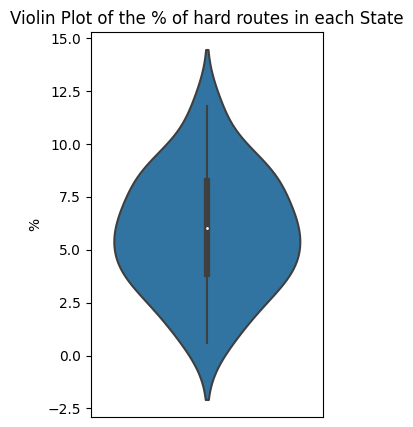

In [30]:
# Calculate the mean ratio of hard sport routes for each State.
hard_merged['% of the States total'].mean().round(2)

# Plot the mean and Standard deviation of the percentage of hard sport climbing routes per State.
plt.figure(figsize=(3,5))
hard_vio = sns.violinplot(data= hard_merged, y ='% of the States total', label = 'Mean')
plt.title('Violin Plot of the % of hard routes in each State')
hard_vio.set(ylabel= '%')
hard_vio.tick_params(bottom=False)